In [1]:
!pip install -q scikit-learn imbalanced-learn xgboost pandas numpy matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
RANDOM_STATE = 42


In [7]:
df = pd.read_csv('/content/Updated_Wine_Dataset.csv')  #/content/Updated_Wine_Dataset.csv
print("Raw data shape:", df.shape)
print("Missing values:\n", df.isna().sum())
print("\nNumber of duplicate rows:", df.duplicated().sum())


df['free_total_sulf_ratio'] = df['free sulfur dioxide'] / (df['total sulfur dioxide'] + 1)

skewed = ['residual sugar','chlorides','sulphates',
          'total sulfur dioxide','free sulfur dioxide']
for col in skewed:
    df[col] = np.log1p(df[col])




Raw data shape: (4898, 13)
Missing values:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine color              0
dtype: int64

Number of duplicate rows: 937


In [8]:
df = df.drop_duplicates().reset_index(drop=True)
print("Cleaned data shape:", df.shape)


Cleaned data shape: (3961, 14)


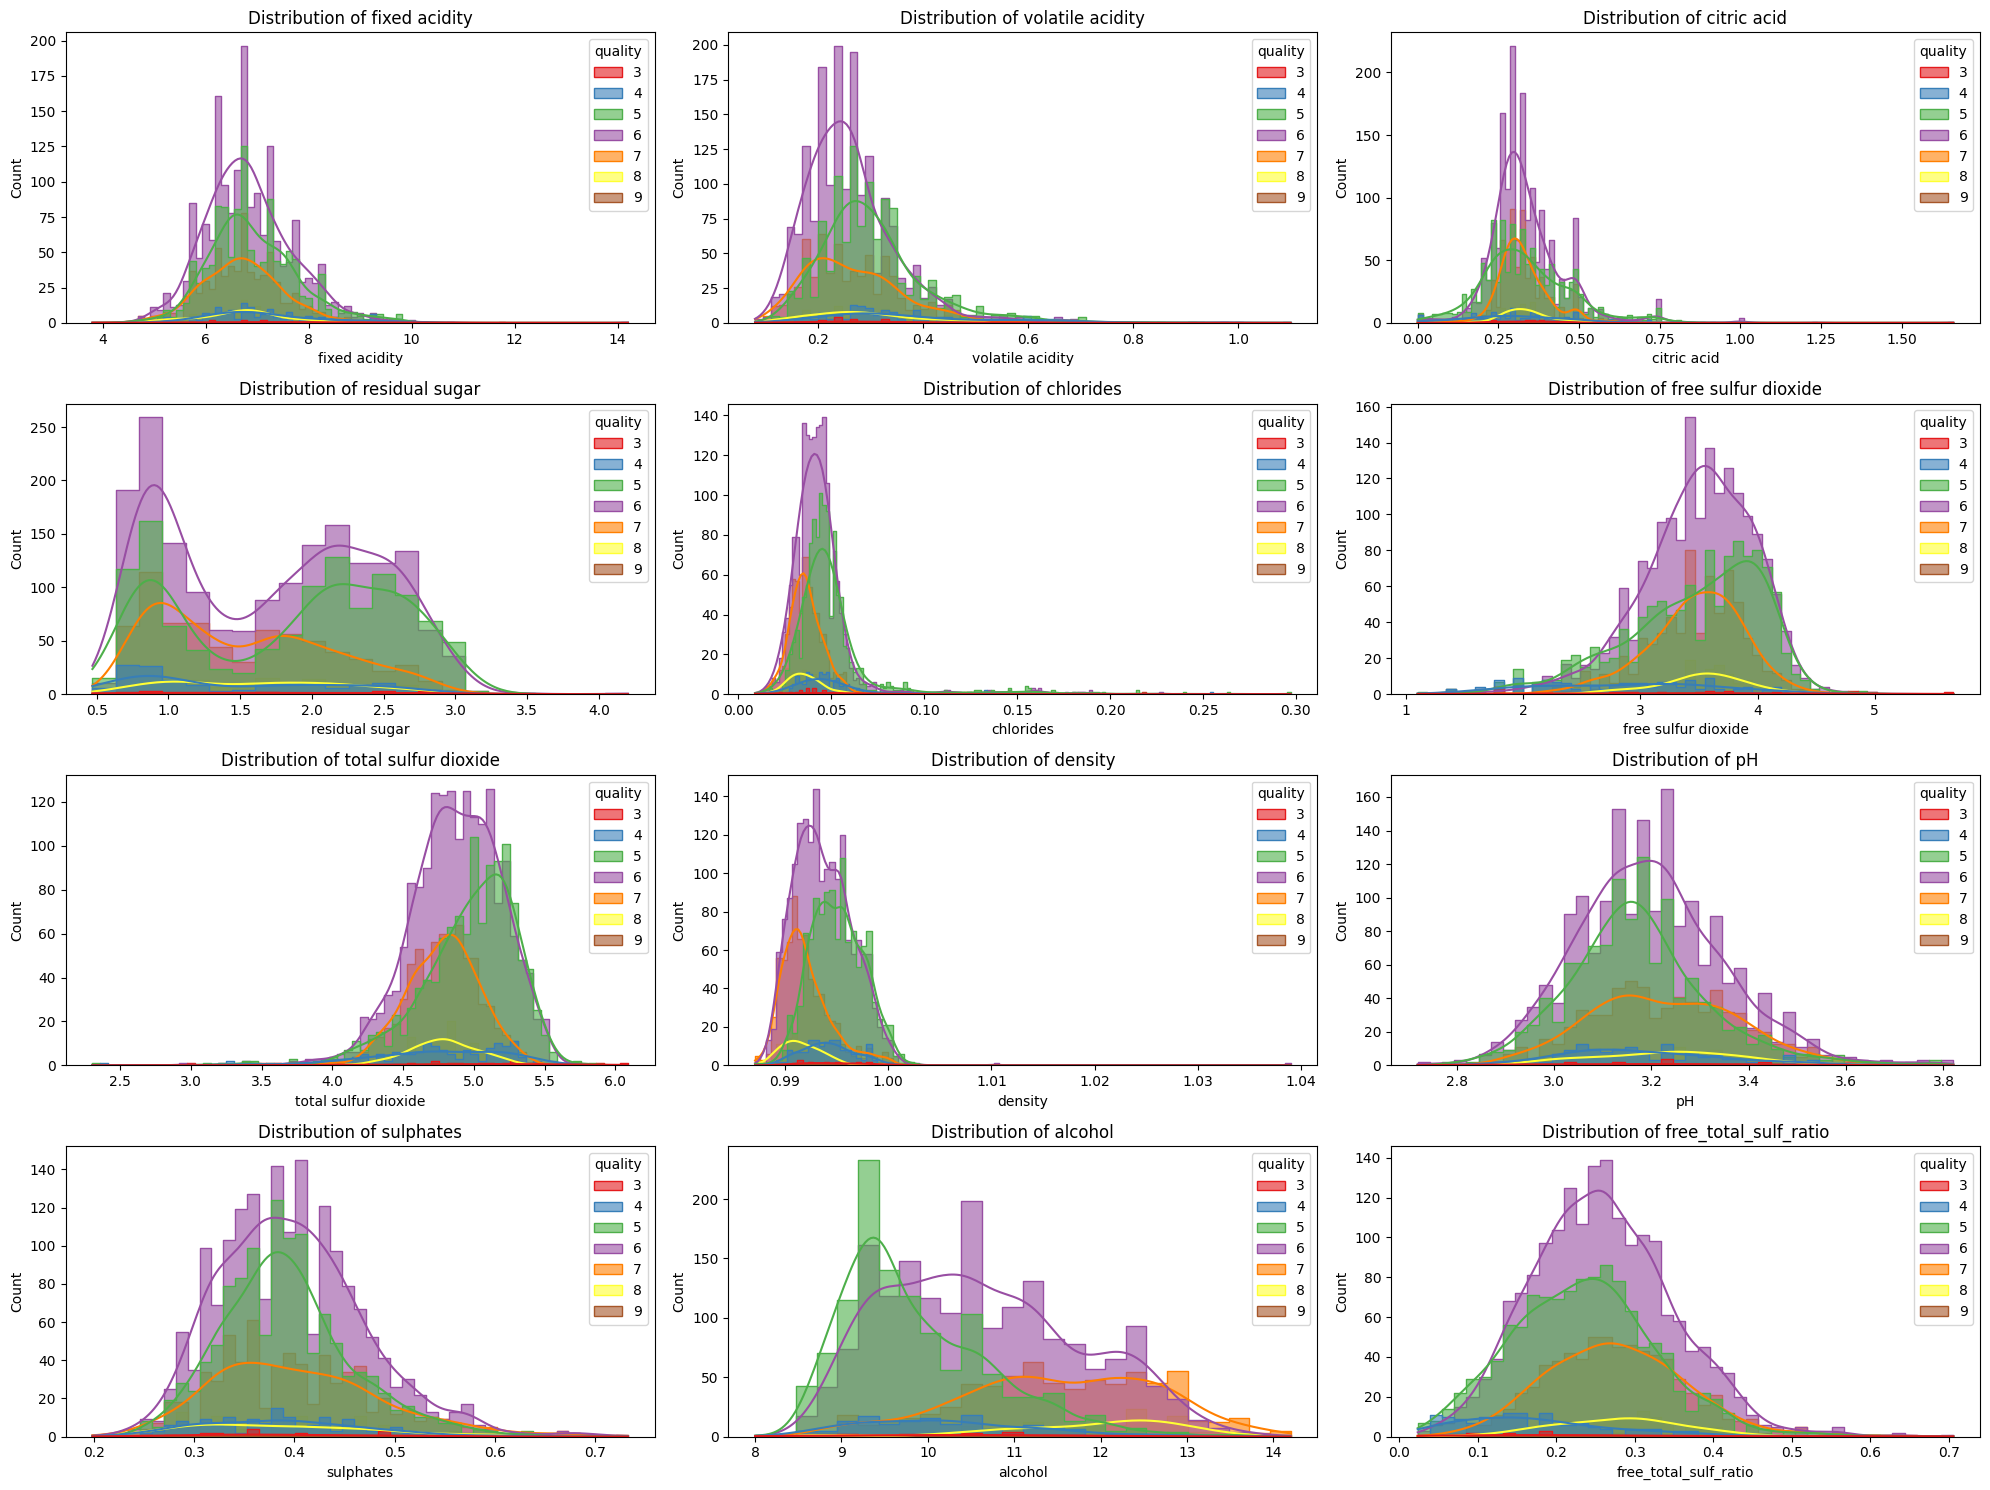

In [9]:
df['target'] = (df['quality'] >= 7).astype(int)
df['target'].value_counts()

fig, axs = plt.subplots(4, 3, figsize=(20, 15))
axs = axs.flatten()

palette = sns.color_palette('Set1', n_colors=df['quality'].nunique())

for i, col in enumerate(df.drop(['quality', 'target', 'wine color'], axis=1).columns[:12]):
    sns.histplot(
        data=df, x=col, hue='quality', ax=axs[i],
        kde=True, element="step", palette=palette, alpha=0.6
    )
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [13]:
df['log_sugar']  = np.log1p(df['residual sugar'])
df['log_sulfur'] = np.log1p(df['total sulfur dioxide'])

X = df.drop(['quality', 'target'], axis=1)
y = df['target']


numeric_features   = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['wine color']


In [14]:
X = df.drop(['quality', 'target'], axis=1)
y = df['target']

from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.20, stratify=y_temp, random_state=RANDOM_STATE)

print('train', X_train.shape, 'val', X_val.shape, 'test', X_test.shape)

train (2534, 15) val (634, 15) test (793, 15)


In [15]:
numeric_features.append('log_sugar')
numeric_features.append('log_sulfur')
X = df.drop(['quality', 'target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)

print("Training distribution:\n", y_train.value_counts(normalize=True))
print("\nTest distribution:\n", y_test.value_counts(normalize=True))


Training distribution:
 target
0    0.791667
1    0.208333
Name: proportion, dtype: float64

Test distribution:
 target
0    0.791929
1    0.208071
Name: proportion, dtype: float64


In [16]:
display(df.isna().sum())
display(df.describe())


,0
fixed acidity,0
volatile acidity,0
citric acid,0
residual sugar,0
chlorides,0
free sulfur dioxide,0
total sulfur dioxide,0
density,0
pH,0
sulphates,0


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,free_total_sulf_ratio,target,log_sugar,log_sulfur
count,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000,3961.000000
mean,6.839346,0.280538,0.334332,1.688150,0.044655,3.456563,4.875965,0.993790,3.195458,0.396216,10.589358,5.854835,0.252508,0.208281,0.952618,1.769132
std,0.866860,0.103437,0.122446,0.710091,0.021012,0.529867,0.338556,0.002905,0.151546,0.074166,1.217076,0.890683,0.094122,0.406130,0.271987,0.059761
min,3.800000,0.080000,0.000000,0.470004,0.008960,1.098612,2.302585,0.987110,2.720000,0.198851,8.000000,3.000000,0.023438,0.000000,0.385265,1.194706
25%,6.300000,0.210000,0.270000,0.955511,0.034401,3.178054,4.672829,0.991620,3.090000,0.343590,9.500000,5.000000,0.187050,0.000000,0.670652,1.735688
50%,6.800000,0.260000,0.320000,1.740466,0.041142,3.526361,4.897840,0.993500,3.180000,0.392042,10.400000,6.000000,0.250000,0.000000,1.008128,1.774586
75%,7.300000,0.330000,0.390000,2.292535,0.048790,3.828641,5.117994,0.995710,3.290000,0.438255,11.400000,6.000000,0.312000,0.000000,1.191658,1.811234
max,14.200000,1.100000,1.660000,4.201703,0.297137,5.669881,6.089045,1.038980,3.820000,0.732368,14.200000,9.000000,0.705882,1.000000,1.648986,1.958551


In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(3168, 15) (793, 15) (3168,) (793,)


In [18]:
numeric_features   = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = ['wine color']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [19]:
RANDOM_STATE = 42
POS_WEIGHT   = 3.8   # ≈ neg / pos

models = {

    'LogReg': LogisticRegression(
        solver='liblinear', C=1.0, class_weight='balanced',
        max_iter=1000, random_state=RANDOM_STATE),


    'RandomForest': RandomForestClassifier(
        n_estimators=500, min_samples_split=4, min_samples_leaf=2,
        class_weight='balanced_subsample', n_jobs=-1, random_state=RANDOM_STATE),


    'GradBoost': GradientBoostingClassifier(
        n_estimators=500, learning_rate=0.05, max_depth=3,
        subsample=0.8, random_state=RANDOM_STATE),


    'XGBoost': XGBClassifier(
        n_estimators=600, learning_rate=0.03, max_depth=4,
        subsample=0.8, colsample_bytree=0.8,
        scale_pos_weight=POS_WEIGHT,
        objective='binary:logistic', eval_metric='logloss',
        n_jobs=-1, random_state=RANDOM_STATE),

    # — SVM —
    'SVC': SVC(
        kernel='rbf', C=5, gamma='scale',
        probability=True, class_weight='balanced',
        random_state=RANDOM_STATE),


    'KNN1': KNeighborsClassifier(
        n_neighbors=5,   weights='uniform',  p=2),
    'KNN2': KNeighborsClassifier(
        n_neighbors=10,  weights='distance', p=2),
    'KNN3': KNeighborsClassifier(
        n_neighbors=21,  weights='distance', p=2)
}


,accuracy_mean,accuracy_std,precision_mean,precision_std,recall_mean,recall_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
RandomForest,0.806,0.019,0.532,0.040,0.617,0.021,0.571,0.029,0.841,0.020
LogReg,0.744,0.021,0.437,0.027,0.783,0.045,0.561,0.029,0.822,0.016
XGBoost,0.732,0.020,0.424,0.022,0.792,0.042,0.552,0.024,0.830,0.018
SVC,0.762,0.009,0.453,0.013,0.676,0.033,0.542,0.016,0.812,0.013
KNN2,0.716,0.011,0.407,0.009,0.788,0.026,0.536,0.010,0.818,0.021
GradBoost,0.795,0.019,0.508,0.040,0.564,0.053,0.534,0.043,0.827,0.021
KNN3,0.686,0.019,0.383,0.015,0.832,0.027,0.525,0.016,0.823,0.014
KNN1,0.713,0.013,0.400,0.014,0.750,0.035,0.521,0.019,0.788,0.026


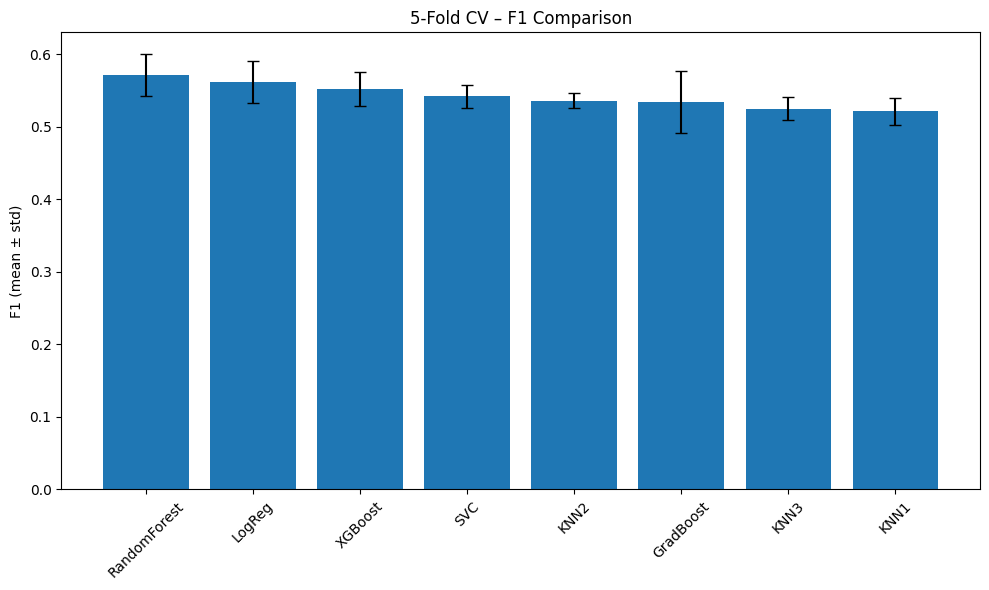

In [20]:
cv_results = {}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

for name, clf in models.items():
    pipe = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', clf)
    ])
    scores = cross_validate(
        pipe, X_train, y_train, cv=cv,
        scoring=scoring, n_jobs=-1, return_train_score=False
    )

    # store mean + std
    cv_results[name] = {f'{m}_mean': scores[f'test_{m}'].mean()
                        for m in scoring} | {
                        f'{m}_std' : scores[f'test_{m}'].std()
                        for m in scoring}

# Convert to DataFrame, sort by F1 mean
cols = sum([[f'{m}_mean', f'{m}_std'] for m in scoring], [])
results_df = (
    pd.DataFrame(cv_results).T[cols]
      .sort_values(by='f1_mean', ascending=False)
      .round(3)
)
display(results_df)



plt.figure(figsize=(10, 6))
plt.bar(
      x=results_df.index,
    height=results_df['f1_mean'],
    yerr=results_df['f1_std'],
    capsize=4
)
plt.ylabel('F1 (mean ± std)'); plt.title('5-Fold CV – F1 Comparison')
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

In [21]:
param_grid = {
    'model__n_estimators'     : [300, 500, 800],
    'model__max_depth'        : [None, 10, 20],
    'model__min_samples_split': [2, 4, 6],
    'model__min_samples_leaf' : [1, 2, 4],
    'model__max_features'     : ['sqrt', 'log2'],
}

pipe = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('model', models['RandomForest'])
])

grid = GridSearchCV(
    pipe, param_grid, cv=cv,
    scoring='f1', n_jobs=-1, verbose=2
)

grid.fit(X_train, y_train)

print("Best Hyper-Param:", grid.best_params_)
print("Best CV F1:", grid.best_score_.round(3))
best_model = grid.best_estimator_


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Hyper-Param: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 800}
Best CV F1: 0.575


Accuracy : 0.8234552332912989
Precision: 0.5647668393782384
Recall   : 0.6606060606060606
F1-Score : 0.6089385474860335
ROC-AUC  : 0.8555201698513801

Classification Report
               precision    recall  f1-score   support

           0       0.91      0.87      0.89       628
           1       0.56      0.66      0.61       165

    accuracy                           0.82       793
   macro avg       0.74      0.76      0.75       793
weighted avg       0.84      0.82      0.83       793



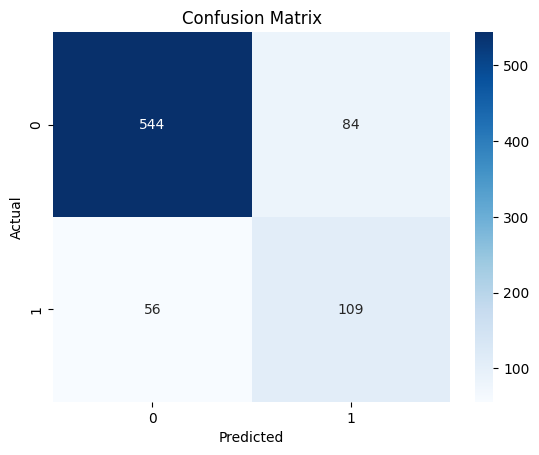

In [22]:
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-Score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba))

print("\nClassification Report\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

In [23]:

import joblib
joblib.dump(best_model, 'white_wine_quality_model.pkl')


['white_wine_quality_model.pkl']

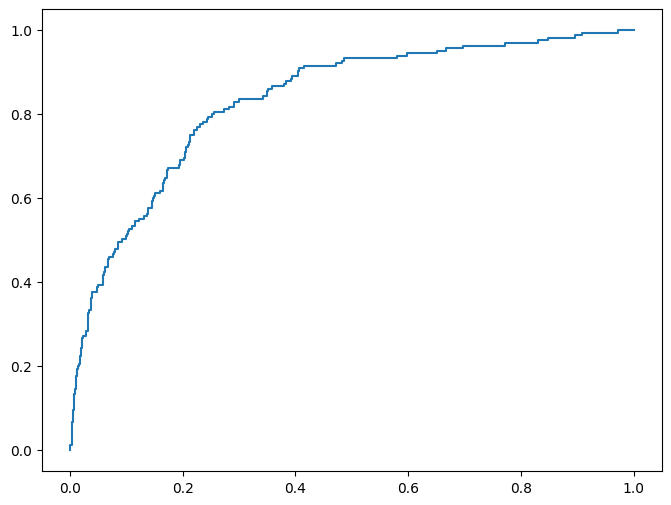

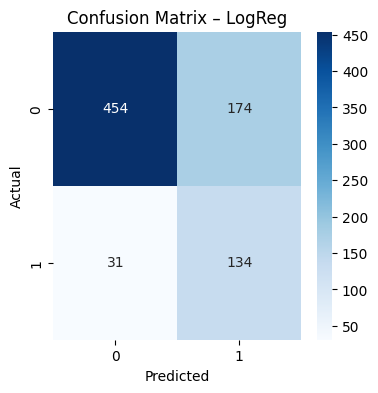


Classification Report – LogReg

              precision    recall  f1-score   support

           0      0.936     0.723     0.816       628
           1      0.435     0.812     0.567       165

    accuracy                          0.741       793
   macro avg      0.686     0.768     0.691       793
weighted avg      0.832     0.741     0.764       793



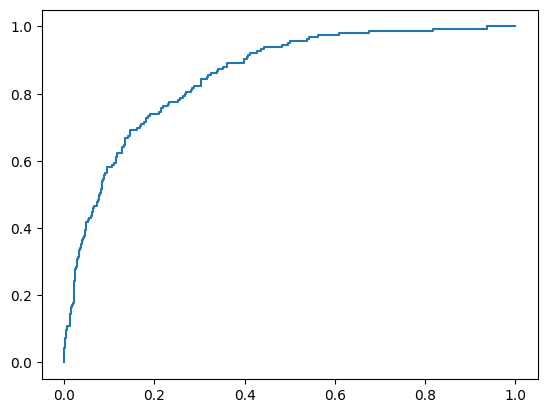

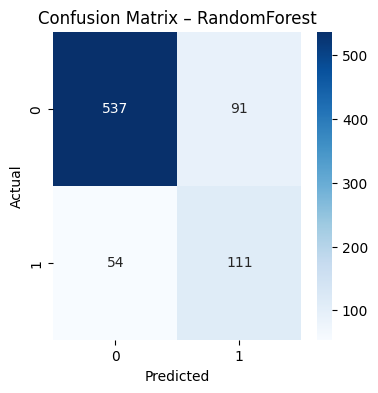


Classification Report – RandomForest

              precision    recall  f1-score   support

           0      0.909     0.855     0.881       628
           1      0.550     0.673     0.605       165

    accuracy                          0.817       793
   macro avg      0.729     0.764     0.743       793
weighted avg      0.834     0.817     0.824       793



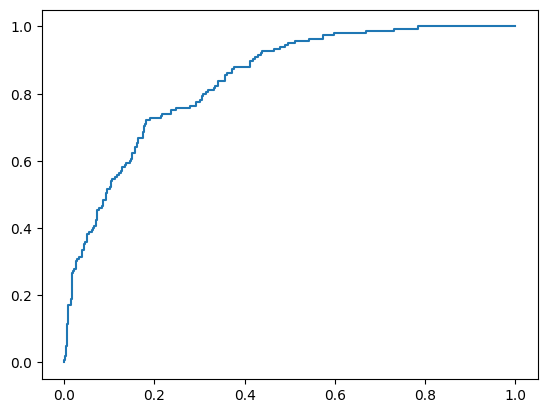

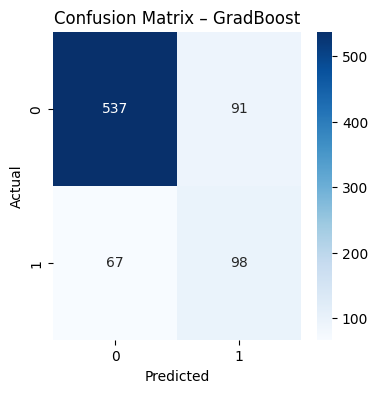


Classification Report – GradBoost

              precision    recall  f1-score   support

           0      0.889     0.855     0.872       628
           1      0.519     0.594     0.554       165

    accuracy                          0.801       793
   macro avg      0.704     0.725     0.713       793
weighted avg      0.812     0.801     0.806       793



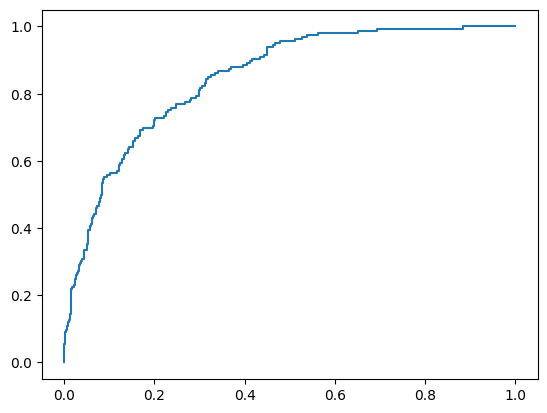

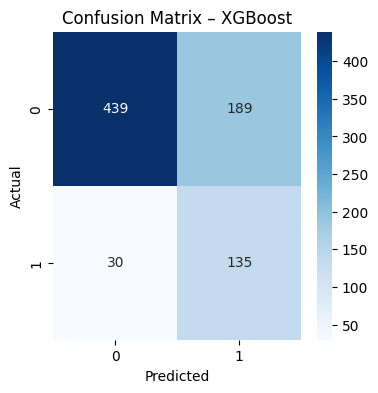


Classification Report – XGBoost

              precision    recall  f1-score   support

           0      0.936     0.699     0.800       628
           1      0.417     0.818     0.552       165

    accuracy                          0.724       793
   macro avg      0.676     0.759     0.676       793
weighted avg      0.828     0.724     0.749       793



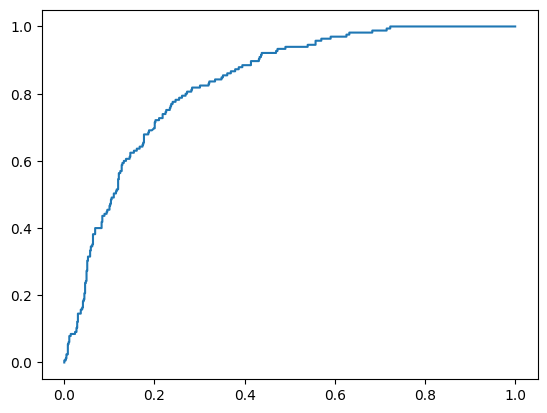

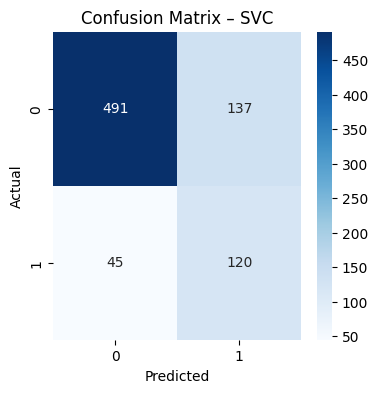


Classification Report – SVC

              precision    recall  f1-score   support

           0      0.916     0.782     0.844       628
           1      0.467     0.727     0.569       165

    accuracy                          0.770       793
   macro avg      0.691     0.755     0.706       793
weighted avg      0.823     0.770     0.786       793



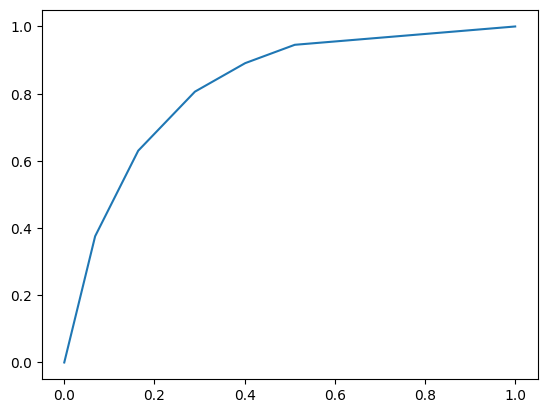

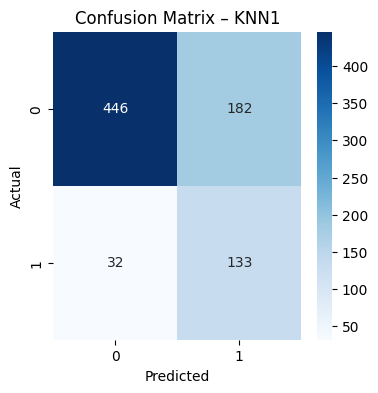


Classification Report – KNN1

              precision    recall  f1-score   support

           0      0.933     0.710     0.807       628
           1      0.422     0.806     0.554       165

    accuracy                          0.730       793
   macro avg      0.678     0.758     0.680       793
weighted avg      0.827     0.730     0.754       793



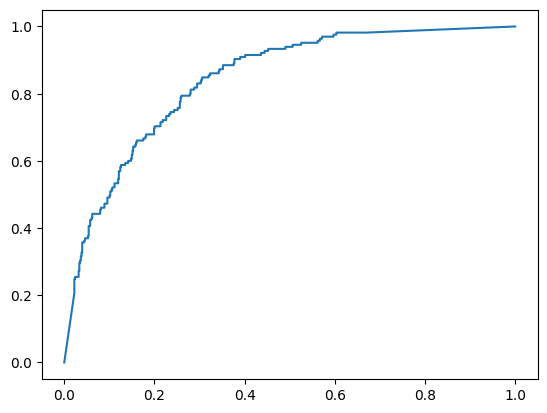

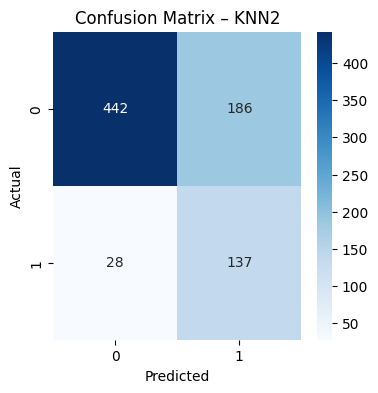


Classification Report – KNN2

              precision    recall  f1-score   support

           0      0.940     0.704     0.805       628
           1      0.424     0.830     0.561       165

    accuracy                          0.730       793
   macro avg      0.682     0.767     0.683       793
weighted avg      0.833     0.730     0.754       793



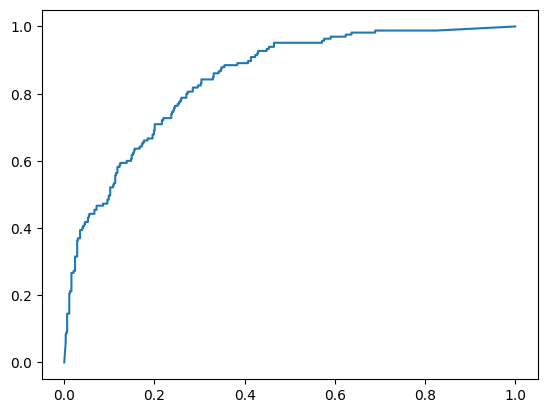

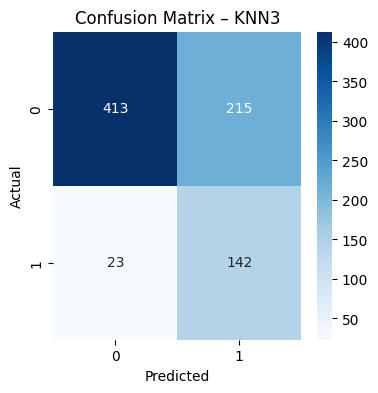


Classification Report – KNN3

              precision    recall  f1-score   support

           0      0.947     0.658     0.776       628
           1      0.398     0.861     0.544       165

    accuracy                          0.700       793
   macro avg      0.673     0.759     0.660       793
weighted avg      0.833     0.700     0.728       793



<ipython-input-25-405ea41ededd>:56: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


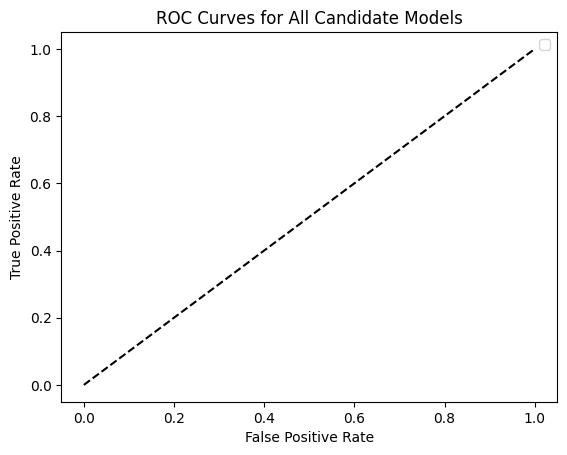

,model,accuracy,precision,recall,f1,roc_auc
0,RandomForest,0.817150,0.549505,0.672727,0.604905,0.855588
1,SVC,0.770492,0.466926,0.727273,0.568720,0.832672
2,LogReg,0.741488,0.435065,0.812121,0.566596,0.833430
3,KNN2,0.730139,0.424149,0.830303,0.561475,0.841937
4,KNN1,0.730139,0.422222,0.806061,0.554167,0.822250
5,GradBoost,0.800757,0.518519,0.593939,0.553672,0.841980
6,XGBoost,0.723834,0.416667,0.818182,0.552147,0.848485
7,KNN3,0.699874,0.397759,0.860606,0.544061,0.845213


In [25]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

metrics_list = []

plt.figure(figsize=(8, 6))
for name, clf in models.items():

    pipe = ImbPipeline(steps=[
        ('preprocess', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', clf)
    ])


    pipe.fit(X_train, y_train)
    y_pred  = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]

    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec  = recall_score(y_test, y_pred)
    f1   = f1_score(y_test, y_pred)
    rocA = roc_auc_score(y_test, y_proba)

    metrics_list.append({
        'model'    : name,
        'accuracy' : acc,
        'precision': prec,
        'recall'   : rec,
        'f1'       : f1,
        'roc_auc'  : rocA
    })


    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {rocA:.3f})')


    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix – {name}')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()


    print(f'\n{"="*60}\nClassification Report – {name}\n')
    print(classification_report(y_test, y_pred, digits=3))


plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves for All Candidate Models')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


metrics_df = pd.DataFrame(metrics_list).sort_values(by='f1', ascending=False)
display(metrics_df.reset_index(drop=True))
